In [84]:
import os
import geopandas as gpd
import pandas as pd
import requests
import time
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# 설정
csv_dir = r"D:\Landslide\labels\gyeongnam_landslide_2011_2023.gpkg"
date_column = 'date'
latitude_column = 'y'
longitude_column = 'x'
SERVICE_KEY = os.environ.get("KMA_SERVICE_KEY", "5LGEH7S2SVSxhB-0tnlUlA")
GRIB_API_BASE = "https://apihub.kma.go.kr/api/typ06/url/nwp_vars_down.php"
GRIB_DIR = r"D:\Landslide\data\LDAPS\GRIB_labels"
os.makedirs(GRIB_DIR, exist_ok=True)

# 데이터 로드
df = gpd.read_file(csv_dir)
print("데이터 형태:", df.shape)
print("\n모든 컬럼:", df.columns.tolist())
print("\n원본 CRS:", df.crs)

# EPSG:5179 -> EPSG:4326 (WGS84) 좌표 변환
if df.crs and df.crs.to_epsg() != 4326:
    print(f"좌표계 변환: {df.crs} -> EPSG:4326")
    df = df.to_crs(epsg=4326)
    print("변환 완료!")

# geometry에서 위경도 추출
df['lat_wgs84'] = df.geometry.y
df['lon_wgs84'] = df.geometry.x

# fid 컬럼이 없으면 인덱스를 fid로 사용
if 'fid' not in df.columns:
    df['fid'] = df.index
    print("\nfid 컬럼이 없어서 인덱스를 fid로 사용합니다.")

print("\n첫 5행 (변환된 좌표):")
print(df[['fid', date_column, 'lat_wgs84', 'lon_wgs84']].head())

# 날짜 범위가 있는 데이터만 필터링
df_range = df[df[date_column].astype(str).str.contains('~')]
print(f"\n전체 데이터: {len(df)}개")
print(f"날짜 범위 데이터: {len(df_range)}개")
print(f"단일 날짜 데이터: {len(df) - len(df_range)}개 (스킵)")
print("\n날짜 범위 샘플:")
print(df_range[[date_column, 'fid']].head(10))

데이터 형태: (1343, 11)

모든 컬럼: ['date', 'ADRES', 'RN_ADRES', 'CTPRVN_CD', 'SGG_CD', 'EMD_CD', 'AMT_DAMG', 'date_1', 'x', 'y', 'geometry']

원본 CRS: EPSG:5179
좌표계 변환: EPSG:5179 -> EPSG:4326
변환 완료!

fid 컬럼이 없어서 인덱스를 fid로 사용합니다.

첫 5행 (변환된 좌표):
   fid      date  lat_wgs84   lon_wgs84
0    0  20110709  35.070233  128.634900
1    1  20110709  35.175038  128.038560
2    2  20110709  35.142068  128.171511
3    3  20110709  35.150309  128.044733
4    4  20110709  35.114670  128.225066

전체 데이터: 1343개
날짜 범위 데이터: 428개
단일 날짜 데이터: 915개 (스킵)

날짜 범위 샘플:
                  date  fid
915  20200629~20200630  915
916  20200629~20200630  916
917  20200712~20200713  917
918  20200712~20200713  918
919  20200712~20200713  919
920  20200712~20200713  920
921  20200712~20200713  921
922  20200712~20200713  922
923  20200712~20200713  923
924  20200712~20200713  924


In [85]:
def parse_date_range(date_str):
    """날짜 문자열을 파싱하여 시작일과 종료일 반환"""
    # 문자열 정리 (공백, 개행 등 제거)
    date_str = str(date_str).strip()
    
    if '~' in date_str:
        parts = date_str.split('~')
        start_str = parts[0].strip()
        end_str = parts[1].strip()
        
        # 숫자만 추출
        start_digits = ''.join(filter(str.isdigit, start_str))
        end_digits = ''.join(filter(str.isdigit, end_str))
        
        # 8자리가 아니면 에러 출력
        if len(start_digits) < 8 or len(end_digits) < 8:
            raise ValueError(f"날짜 형식 오류: '{date_str}' -> start='{start_digits}', end='{end_digits}'")
        
        # 정확히 8자리만 사용
        start_str = start_digits[:8]
        end_str = end_digits[:8]
        
        start_date = datetime.strptime(start_str, '%Y%m%d')
        end_date = datetime.strptime(end_str, '%Y%m%d')
    else:
        # 숫자만 추출
        date_digits = ''.join(filter(str.isdigit, date_str))
        
        if len(date_digits) < 8:
            raise ValueError(f"날짜 형식 오류: '{date_str}' -> digits='{date_digits}'")
        
        # 정확히 8자리만 사용
        date_str = date_digits[:8]
        start_date = datetime.strptime(date_str, '%Y%m%d')
        end_date = start_date
    
    return start_date, end_date

def generate_date_list(start_date, end_date):
    """시작일부터 종료일까지의 날짜 리스트 생성"""
    dates = []
    current = start_date
    while current <= end_date:
        dates.append(current)
        current += timedelta(days=1)
    return dates

# 실제 데이터로 테스트
print("실제 날짜 데이터 샘플 테스트:")
for i, date_val in enumerate(df_range[date_column].head(10)):
    try:
        start, end = parse_date_range(date_val)
        print(f"{i+1}. '{date_val}' -> {start.date()} ~ {end.date()} ✓")
    except Exception as e:
        print(f"{i+1}. '{date_val}' -> ERROR: {e}")

실제 날짜 데이터 샘플 테스트:
1. '20200629~20200630' -> 2020-06-29 ~ 2020-06-30 ✓
2. '20200629~20200630' -> 2020-06-29 ~ 2020-06-30 ✓
3. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
4. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
5. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
6. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
7. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
8. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
9. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓
10. '20200712~20200713' -> 2020-07-12 ~ 2020-07-13 ✓


In [86]:
# 415번 인덱스부터 끝까지 날짜 데이터 확인
print("인덱스 415부터 끝까지 날짜 데이터 확인:\n")

problem_dates = []
for i, (idx, row) in enumerate(df_range.iterrows()):
    if i < 414:  # 414까지는 정상
        continue
    
    date_val = str(row[date_column])
    print(f"인덱스 {i+1} (원본 {idx+1}): '{date_val}'")
    print(f"  - 원본 타입: {type(row[date_column])}")
    print(f"  - repr: {repr(date_val)}")
    print(f"  - 길이: {len(date_val)}")
    
    # 숫자 추출 테스트
    if '~' in date_val:
        parts = date_val.split('~')
        start_digits = ''.join(filter(str.isdigit, parts[0]))
        end_digits = ''.join(filter(str.isdigit, parts[1]))
        print(f"  - 시작 숫자: '{start_digits}' (길이: {len(start_digits)})")
        print(f"  - 종료 숫자: '{end_digits}' (길이: {len(end_digits)})")
        
        if len(start_digits) < 8 or len(end_digits) < 8:
            problem_dates.append((i+1, idx+1, date_val))
            print(f"  ⚠️ 문제 발견!")
    else:
        digits = ''.join(filter(str.isdigit, date_val))
        print(f"  - 숫자: '{digits}' (길이: {len(digits)})")
        
        if len(digits) < 8:
            problem_dates.append((i+1, idx+1, date_val))
            print(f"  ⚠️ 문제 발견!")
    
    print()
    
    if i >= 424:  # 처음 10개만 확인
        print(f"... (총 {len(df_range) - 414}개 중 처음 10개만 표시)")
        break

print(f"\n문제가 있는 날짜 데이터: {len(problem_dates)}개")
for idx_count, idx_orig, date_val in problem_dates:
    print(f"  - 인덱스 {idx_count} (원본 {idx_orig}): '{date_val}'")

인덱스 415부터 끝까지 날짜 데이터 확인:

인덱스 415 (원본 1330): '20230810~20230841'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230841'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자: '20230841' (길이: 8)

인덱스 416 (원본 1331): '20230810~20230842'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230842'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자: '20230842' (길이: 8)

인덱스 417 (원본 1332): '20230810~20230843'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230843'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자: '20230843' (길이: 8)

인덱스 418 (원본 1333): '20230810~20230844'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230844'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자: '20230844' (길이: 8)

인덱스 419 (원본 1334): '20230810~20230845'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230845'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자: '20230845' (길이: 8)

인덱스 420 (원본 1335): '20230810~20230846'
  - 원본 타입: <class 'str'>
  - repr: '20230810~20230846'
  - 길이: 17
  - 시작 숫자: '20230810' (길이: 8)
  - 종료 숫자

In [87]:
def download_grib_file(service_key, base_time, lead_hour, variable, output_dir):
    """GRIB 파일 다운로드"""
    url = f'{GRIB_API_BASE}?nwp=l015&sub=unis&vars={variable}&tmfc={base_time}&ef={lead_hour+1}&dataType=GRIB&authKey={service_key}'
    
    filename = f"l015_{base_time}_{variable}_h{lead_hour:03d}.gb2"
    filepath = os.path.join(output_dir, filename)
    
    if os.path.exists(filepath):
        return filepath
    
    try:
        r = requests.get(url, timeout=(10, 180), stream=True)
        
        if r.status_code != 200:
            return None
        
        content_type = r.headers.get('content-type', '')
        if 'application/octet-stream' not in content_type:
            error_text = r.text[:200]
            if "file not exist" in error_text or "파라미터 없음" in error_text:
                return None
        
        with open(filepath, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        
        file_size = os.path.getsize(filepath)
        if file_size > 0:
            return filepath
        else:
            os.remove(filepath)
            return None
            
    except Exception as e:
        return None

def grib_to_xarray(grib_file):
    """GRIB 파일을 xarray로 로드"""
    try:
        ds = xr.open_dataset(grib_file, engine='cfgrib')
        return ds
    except Exception as e:
        return None

In [88]:
def extract_rain_for_point(lat, lon, date_range, service_key):
    """특정 좌표와 날짜 범위에 대한 강우량 추출"""
    daily_rain = []
    
    for day in date_range:
        day_str = day.strftime('%Y%m%d')
        
        # 해당 날짜의 강우 데이터 수집
        hourly_data = []
        
        # 00, 06, 12, 18시 초기시간에서 각각 0~5시간 예보
        for init_hour in [0, 6, 12, 18]:
            base_time = day_str + f"{init_hour:02d}00"
            
            for lead_hour in range(0, 6):
                # GRIB 다운로드
                grib_file = download_grib_file(service_key, base_time, lead_hour, "lspr", GRIB_DIR)
                
                if grib_file is None:
                    continue
                
                # GRIB 로드
                ds = grib_to_xarray(grib_file)
                if ds is None:
                    continue
                
                try:
                    # 강수량 데이터 추출
                    data_vars = list(ds.data_vars.keys())
                    if not data_vars:
                        ds.close()
                        continue
                    
                    var_name = data_vars[0]
                    rain_2d = ds[var_name].values
                    
                    # 위경도 좌표
                    if 'latitude' in ds.coords and 'longitude' in ds.coords:
                        lats = ds['latitude'].values
                        lons = ds['longitude'].values
                    else:
                        ds.close()
                        continue
                    
                    # 가장 가까운 격자점 찾기
                    dist = np.sqrt((lats - lat)**2 + (lons - lon)**2)
                    min_idx = np.unravel_index(np.argmin(dist), dist.shape)
                    
                    # 강수량 추출 (kg m-2 s-1 -> mm/h)
                    rain_value = rain_2d[min_idx] * 3600.0 if not np.isnan(rain_2d[min_idx]) else 0.0
                    hourly_data.append(rain_value)
                    
                    ds.close()
                    
                except Exception as e:
                    if ds is not None:
                        ds.close()
                    continue
                
                time.sleep(0.05)
        
        # 일일 강수량 계산 (mm)
        if hourly_data:
            daily_total = sum(hourly_data)
            daily_rain.append(daily_total)
        else:
            daily_rain.append(0.0)
    
    return daily_rain

In [89]:
def calculate_effective_cumulative_rain(daily_rain, k=0.8):
    """유효 누적 강우량 계산 (3일 누적)
    
    Args:
        daily_rain: 일별 강우량 리스트
        k: 감쇠 계수 (기본값 0.8)
    
    Returns:
        각 일자별 유효 누적 강우량 리스트
    """
    effective_cum_rain = []
    
    for i in range(len(daily_rain)):
        # 당일 + 1일전*k + 2일전*k^2
        cum = daily_rain[i]
        
        if i >= 1:
            cum += k * daily_rain[i-1]
        if i >= 2:
            cum += (k**2) * daily_rain[i-2]
        
        effective_cum_rain.append(cum)
    
    return effective_cum_rain

# 테스트
test_rain = [10, 20, 30, 15, 5]
test_eff = calculate_effective_cumulative_rain(test_rain)
print("일별 강우량:", test_rain)
print("유효 누적 강우량:", [f"{x:.2f}" for x in test_eff])

일별 강우량: [10, 20, 30, 15, 5]
유효 누적 강우량: ['10.00', '28.00', '52.40', '51.80', '36.20']


In [90]:
# 전체 데이터 처리
results = []
output_path = r"D:\Landslide\label_rain_data.csv"

print(f"\n날짜 범위가 있는 {len(df_range)}개 산사태 이벤트 처리 시작...\n")

for count, (idx, row) in enumerate(df_range.iterrows(), 1):
    fid = row['fid']
    date_str = str(row[date_column])
    lat = row['lat_wgs84']  # 변환된 WGS84 좌표 사용
    lon = row['lon_wgs84']
    
    print(f"[{count}/{len(df_range)}] 원본Index={idx+1}, FID={fid}, 날짜={date_str}, 좌표=({lat:.4f}, {lon:.4f})")
    
    # 날짜 범위 파싱
    try:
        start_date, end_date = parse_date_range(date_str)
        date_list_original = generate_date_list(start_date, end_date)
        
        # 유효 누적 강우량 계산을 위해 시작일 -2일부터 데이터 다운로드
        start_date_extended = start_date - timedelta(days=2)
        date_list_extended = generate_date_list(start_date_extended, end_date)
        
        print(f"  요청 기간: {start_date.date()} ~ {end_date.date()} ({len(date_list_original)}일)")
        print(f"  다운로드 기간: {start_date_extended.date()} ~ {end_date.date()} ({len(date_list_extended)}일)")
        
    except Exception as e:
        print(f"  [날짜 파싱 ERROR] {e}")
        # 파싱 실패 시 빈 데이터로 저장
        results.append({
            'index': idx + 1,
            'fid': fid,
            'date': date_str,
            'rain_perday': 'PARSE_ERROR',
            'rain_max': 0.0,
            'max_rain_day': '',
            'valid_cum_rain': '',
            'max_valid_cum_rain': 0.0,
            'max_valid_cum_rain_day': '',
            'latitude': lat,
            'longitude': lon
        })
        print()
        continue
    
    # 강우량 추출 (확장된 기간)
    try:
        daily_rain_extended = extract_rain_for_point(lat, lon, date_list_extended, SERVICE_KEY)
        
        # 원래 요청 기간의 강우량만 추출 (마지막 N일)
        daily_rain = daily_rain_extended[-len(date_list_original):]
        
        # 일별 강수량 문자열 (원래 기간만)
        rain_perday = '-'.join([f"{r:.2f}" for r in daily_rain])
        
        # 최대 강수량 및 날짜 (원래 기간 기준)
        if daily_rain:
            rain_max = max(daily_rain)
            max_rain_idx = daily_rain.index(rain_max)
            max_rain_day = date_list_original[max_rain_idx].strftime('%Y%m%d')
        else:
            rain_max = 0.0
            max_rain_day = ''
        
        # 유효 누적 강우량 계산 (확장된 전체 기간으로 계산)
        valid_cum_rain_extended = calculate_effective_cumulative_rain(daily_rain_extended)
        
        # 원래 요청 기간의 유효 누적 강우량만 추출
        valid_cum_rain = valid_cum_rain_extended[-len(date_list_original):]
        valid_cum_rain_str = '-'.join([f"{r:.2f}" for r in valid_cum_rain])
        
        # 최대 유효 누적 강우량 및 날짜 (원래 기간 기준)
        if valid_cum_rain:
            max_valid_cum = max(valid_cum_rain)
            max_valid_cum_idx = valid_cum_rain.index(max_valid_cum)
            max_valid_cum_rain_day = date_list_original[max_valid_cum_idx].strftime('%Y%m%d')
        else:
            max_valid_cum = 0.0
            max_valid_cum_rain_day = ''
        
        results.append({
            'index': idx + 1,
            'fid': fid,
            'date': date_str,
            'rain_perday': rain_perday,
            'rain_max': rain_max,
            'max_rain_day': max_rain_day,
            'valid_cum_rain': valid_cum_rain_str,
            'max_valid_cum_rain': max_valid_cum,
            'max_valid_cum_rain_day': max_valid_cum_rain_day,
            'latitude': lat,
            'longitude': lon
        })
        
        print(f"  완료: 최대강수량={rain_max:.2f}mm ({max_rain_day}), 최대유효누적={max_valid_cum:.2f}mm ({max_valid_cum_rain_day})\n")
        
    except Exception as e:
        print(f"  [강우량 추출 ERROR] {e}")
        import traceback
        traceback.print_exc()
        # 에러 발생 시에도 빈 데이터로 저장
        results.append({
            'index': idx + 1,
            'fid': fid,
            'date': date_str,
            'rain_perday': '',
            'rain_max': 0.0,
            'max_rain_day': '',
            'valid_cum_rain': '',
            'max_valid_cum_rain': 0.0,
            'max_valid_cum_rain_day': '',
            'latitude': lat,
            'longitude': lon
        })
        print()
    
    # 100개 처리할 때마다 중간 저장
    if count % 100 == 0:
        temp_df = pd.DataFrame(results)
        temp_df.to_csv(output_path, index=False, encoding='utf-8-sig')
        print(f"✓ 중간 저장 완료: {len(results)}개 결과 저장됨 ({output_path})\n")

print(f"\n처리 완료: 총 {len(results)}개 결과")

# 최종 저장
result_df = pd.DataFrame(results)
result_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n최종 저장 완료: {output_path}")
print(f"저장된 데이터 형태: {result_df.shape}")


날짜 범위가 있는 428개 산사태 이벤트 처리 시작...

[1/428] 원본Index=916, FID=915, 날짜=20200629~20200630, 좌표=(35.2365, 127.7466)
  요청 기간: 2020-06-29 ~ 2020-06-30 (2일)
  다운로드 기간: 2020-06-27 ~ 2020-06-30 (4일)
  완료: 최대강수량=109.63mm (20200629), 최대유효누적=109.63mm (20200629)

[2/428] 원본Index=917, FID=916, 날짜=20200629~20200630, 좌표=(35.5225, 128.2131)
  요청 기간: 2020-06-29 ~ 2020-06-30 (2일)
  다운로드 기간: 2020-06-27 ~ 2020-06-30 (4일)
  완료: 최대강수량=49.57mm (20200629), 최대유효누적=49.57mm (20200629)

[3/428] 원본Index=918, FID=917, 날짜=20200712~20200713, 좌표=(34.8512, 128.4448)
  요청 기간: 2020-07-12 ~ 2020-07-13 (2일)
  다운로드 기간: 2020-07-10 ~ 2020-07-13 (4일)
  완료: 최대강수량=93.93mm (20200712), 최대유효누적=119.84mm (20200713)

[4/428] 원본Index=919, FID=918, 날짜=20200712~20200713, 좌표=(34.8291, 128.6585)
  요청 기간: 2020-07-12 ~ 2020-07-13 (2일)
  다운로드 기간: 2020-07-10 ~ 2020-07-13 (4일)
  완료: 최대강수량=129.61mm (20200712), 최대유효누적=163.29mm (20200713)

[5/428] 원본Index=920, FID=919, 날짜=20200712~20200713, 좌표=(35.2497, 127.9444)
  요청 기간: 2020-07-12 ~ 2020-07-13 (2일)


In [91]:
# 최종 결과 확인
print(f"\n결과 요약:")
print(f"- 총 처리된 이벤트: {len(result_df)}개")
print(f"- 저장 경로: {output_path}")
print(f"\n처음 5행:")
print(result_df.head())
print(f"\n마지막 5행:")
print(result_df.tail())
print(f"\n에러 발생 케이스:")
error_cases = result_df[result_df['rain_perday'].isin(['', 'PARSE_ERROR'])]
print(f"- 총 {len(error_cases)}개")
if len(error_cases) > 0:
    print(error_cases[['index', 'fid', 'date', 'rain_perday']])


결과 요약:
- 총 처리된 이벤트: 428개
- 저장 경로: D:\Landslide\label_rain_data.csv

처음 5행:
   index  fid               date   rain_perday    rain_max max_rain_day  \
0    916  915  20200629~20200630   109.63-2.88  109.630661     20200629   
1    917  916  20200629~20200630    49.57-0.33   49.574947     20200629   
2    918  917  20200712~20200713   93.93-44.70   93.931396     20200712   
3    919  918  20200712~20200713  129.61-59.51  129.612930     20200712   
4    920  919  20200712~20200713  153.47-29.20  153.468719     20200712   

  valid_cum_rain  max_valid_cum_rain max_valid_cum_rain_day   latitude  \
0   109.63-90.59          109.630661               20200629  35.236498   
1    49.57-39.99           49.574947               20200629  35.522468   
2   98.75-119.84          119.840164               20200713  34.851245   
3  141.07-163.29          163.285950               20200713  34.829130   
4  157.66-152.40          157.660797               20200712  35.249740   

    longitude  
0  127.74657

산사태 기간 강우량 분석 결과

총 데이터: 428개
유효 데이터: 414개
에러 데이터: 14개

1. 최대 강우량 (rain_max) 통계
평균: 176.14 mm
표준편차: 60.17 mm
최소값: 49.09 mm
1사분위수 (25%): 130.91 mm
2사분위수 (50%, 중앙값): 171.88 mm
3사분위수 (75%): 224.16 mm
최대값: 321.74 mm

2. 최대 유효 누적 강우량 (max_valid_cum_rain) 통계
평균: 219.14 mm
표준편차: 65.34 mm
최소값: 49.57 mm
1사분위수 (25%): 180.09 mm
2사분위수 (50%, 중앙값): 223.86 mm
3사분위수 (75%): 265.51 mm
최대값: 380.11 mm


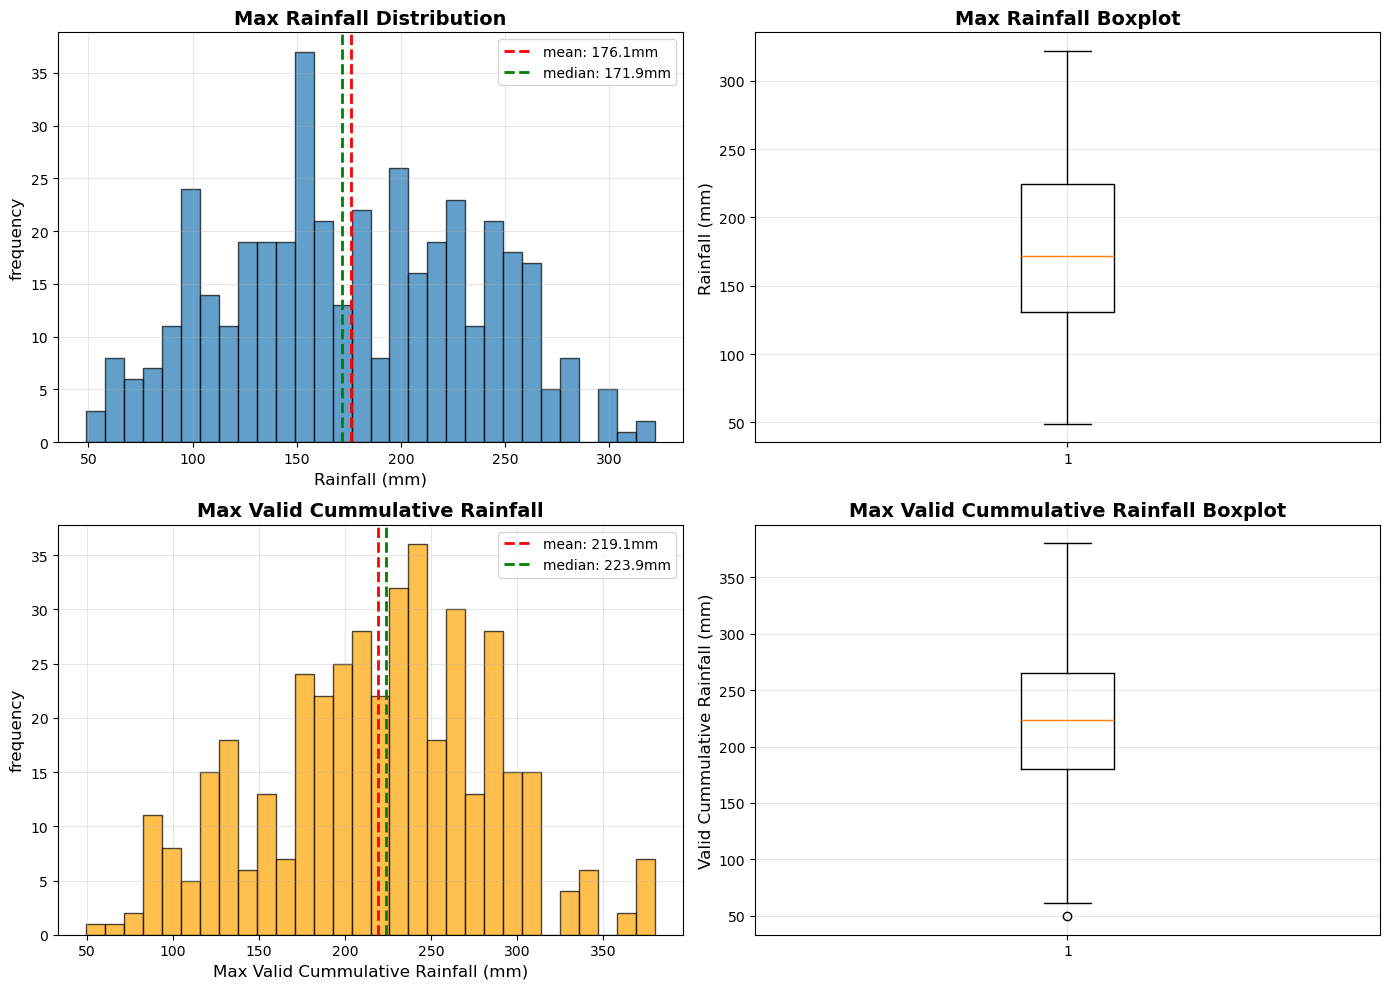


분석 완료


In [94]:
import matplotlib.pyplot as plt

# CSV 파일 로드 (최신 결과)
output_path = r"D:\Landslide\data\gyeongnam\label_rain_data.csv"
result_df = pd.read_csv(output_path)

print("=" * 60)
print("산사태 기간 강우량 분석 결과")
print("=" * 60)

# 에러 케이스 제외
valid_df = result_df[~result_df['rain_perday'].isin(['', 'PARSE_ERROR'])]
print(f"\n총 데이터: {len(result_df)}개")
print(f"유효 데이터: {len(valid_df)}개")
print(f"에러 데이터: {len(result_df) - len(valid_df)}개")

# 1. 최대 강우량 통계
print("\n" + "=" * 60)
print("1. 최대 강우량 (rain_max) 통계")
print("=" * 60)
rain_max_data = valid_df['rain_max']
print(f"평균: {rain_max_data.mean():.2f} mm")
print(f"표준편차: {rain_max_data.std():.2f} mm")
print(f"최소값: {rain_max_data.min():.2f} mm")
print(f"1사분위수 (25%): {rain_max_data.quantile(0.25):.2f} mm")
print(f"2사분위수 (50%, 중앙값): {rain_max_data.quantile(0.50):.2f} mm")
print(f"3사분위수 (75%): {rain_max_data.quantile(0.75):.2f} mm")
print(f"최대값: {rain_max_data.max():.2f} mm")

# 2. 최대 유효 누적 강우량 통계
print("\n" + "=" * 60)
print("2. 최대 유효 누적 강우량 (max_valid_cum_rain) 통계")
print("=" * 60)
valid_cum_data = valid_df['max_valid_cum_rain']
print(f"평균: {valid_cum_data.mean():.2f} mm")
print(f"표준편차: {valid_cum_data.std():.2f} mm")
print(f"최소값: {valid_cum_data.min():.2f} mm")
print(f"1사분위수 (25%): {valid_cum_data.quantile(0.25):.2f} mm")
print(f"2사분위수 (50%, 중앙값): {valid_cum_data.quantile(0.50):.2f} mm")
print(f"3사분위수 (75%): {valid_cum_data.quantile(0.75):.2f} mm")
print(f"최대값: {valid_cum_data.max():.2f} mm")

# 3. 시각화
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 3-1. 최대 강우량 히스토그램
axes[0, 0].hist(rain_max_data, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(rain_max_data.mean(), color='red', linestyle='--', linewidth=2, label=f'mean: {rain_max_data.mean():.1f}mm')
axes[0, 0].axvline(rain_max_data.median(), color='green', linestyle='--', linewidth=2, label=f'median: {rain_max_data.median():.1f}mm')
axes[0, 0].set_title('Max Rainfall Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Rainfall (mm)', fontsize=12)
axes[0, 0].set_ylabel('frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 3-2. 최대 강우량 박스플롯
axes[0, 1].boxplot(rain_max_data, vert=True)
axes[0, 1].set_title('Max Rainfall Boxplot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Rainfall (mm)', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# 3-3. 최대 유효 누적 강우량 히스토그램
axes[1, 0].hist(valid_cum_data, bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].axvline(valid_cum_data.mean(), color='red', linestyle='--', linewidth=2, label=f'mean: {valid_cum_data.mean():.1f}mm')
axes[1, 0].axvline(valid_cum_data.median(), color='green', linestyle='--', linewidth=2, label=f'median: {valid_cum_data.median():.1f}mm')
axes[1, 0].set_title('Max Valid Cummulative Rainfall', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Max Valid Cummulative Rainfall (mm)', fontsize=12)
axes[1, 0].set_ylabel('frequency', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 3-4. 최대 유효 누적 강우량 박스플롯
axes[1, 1].boxplot(valid_cum_data, vert=True)
axes[1, 1].set_title('Max Valid Cummulative Rainfall Boxplot', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Valid Cummulative Rainfall (mm)', fontsize=12)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("분석 완료")
print("=" * 60)

In [95]:
# appr_date 선정 규칙 적용
output_path = r"D:\Landslide\data\gyeongnam\label_rain_data.csv"

# 기준값: 전체 산사태의 최대 유효 누적 강우량 평균
threshold = valid_df['max_valid_cum_rain'].mean()
print(f"\n기준값 (최대 유효 누적 강우량 평균): {threshold:.1f} mm")

def select_appr_date(row):
    """핵심 유발일 선정"""
    # 에러 케이스
    if row['rain_perday'] in ['', 'PARSE_ERROR'] or pd.isna(row['rain_max']):
        return ''
    
    # 예외 규칙: 최대 강우량이 기준값(219.1mm)을 초과하는 경우
    if row['rain_max'] > threshold:
        return row['max_rain_day']
    
    # 기본 규칙: 유효 누적 강우량 최대일
    return row['max_valid_cum_rain_day']

# appr_date 컬럼 추가
result_df['appr_date'] = result_df.apply(select_appr_date, axis=1)

# 결과 통계
print("\n" + "=" * 60)
print("핵심 유발일 선정 결과")
print("=" * 60)

valid_appr = result_df[result_df['appr_date'] != '']
total_events = len(valid_appr)

# 기본 규칙 적용된 건수
basic_rule = result_df[result_df['appr_date'] == result_df['max_valid_cum_rain_day']]
# 예외 규칙 적용된 건수
exception_rule = result_df[(result_df['appr_date'] == result_df['max_rain_day']) & 
                            (result_df['appr_date'] != result_df['max_valid_cum_rain_day'])]

print(f"\n총 처리 건수: {total_events}개")
print(f"기본 규칙 적용 (유효 누적 최대일): {len(basic_rule)}개 ({len(basic_rule)/total_events*100:.1f}%)")
print(f"예외 규칙 적용 (최대 강우일): {len(exception_rule)}개 ({len(exception_rule)/total_events*100:.1f}%)")

# 예외 규칙 적용 사례 샘플
if len(exception_rule) > 0:
    print(f"\n예외 규칙 적용 사례 (최대 강우량 > {threshold:.1f}mm):")
    print(exception_rule[['index', 'date', 'rain_max', 'max_rain_day', 'max_valid_cum_rain', 'max_valid_cum_rain_day', 'appr_date']].head(10))

# CSV 저장
result_df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"\n저장 완료: {output_path}")
print(f"\n컬럼 목록:")
print(result_df.columns.tolist())


기준값 (최대 유효 누적 강우량 평균): 219.1 mm

핵심 유발일 선정 결과

총 처리 건수: 414개
기본 규칙 적용 (유효 누적 최대일): 353개 (85.3%)
예외 규칙 적용 (최대 강우일): 61개 (14.7%)

예외 규칙 적용 사례 (최대 강우량 > 219.1mm):
     index               date    rain_max  max_rain_day  max_valid_cum_rain  \
44     960  20200728~20200811  262.889099    20200807.0          360.057251   
74     990  20200728~20200811  252.322464    20200807.0          291.628021   
77     993  20200728~20200811  239.378357    20200807.0          276.362457   
78     994  20200728~20200811  244.374542    20200807.0          281.612305   
79     995  20200728~20200811  264.541351    20200807.0          302.798889   
81     997  20200728~20200811  258.597565    20200807.0          290.868164   
82     998  20200728~20200811  222.146973    20200807.0          255.840332   
83     999  20200728~20200811  222.106659    20200807.0          259.772003   
84    1000  20200728~20200811  230.554962    20200807.0          259.071106   
102   1018  20200728~20200811  222.775269    2020

In [97]:
# 라벨 csv 파일 만들기
print("=" * 60)
print("최종 라벨 파일 생성")
print("=" * 60)

# 1. 원본 gpkg 파일 로드 (이미 로드되어 있음: df)
print(f"\n원본 데이터: {len(df)}개")

# 2. 생성된 강우량 CSV 로드
rain_csv_path = r"D:\Landslide\data\gyeongnam\label_rain_data.csv"
rain_df = pd.read_csv(rain_csv_path)
print(f"강우량 데이터: {len(rain_df)}개")

# 3. 최종 라벨 데이터 생성
label_data = []

for idx, row in df.iterrows():
    date_str = str(row[date_column])
    
    # fid (인덱스 + 1)
    fid = idx + 1
    
    # 좌표 (WGS84)
    lat = row['lat_wgs84']
    lon = row['lon_wgs84']
    
    # 피해 정도
    avg_damg = row['AMT_DAMG'] if 'AMT_DAMG' in row else 0
    
    # 날짜 결정
    if '~' in date_str:
        # 기간으로 되어 있는 경우 -> rain_df에서 appr_date 찾기
        # index 칼럼을 기준으로 매칭 (원본 인덱스 + 1)
        matched = rain_df[rain_df['index'] == fid]
        
        if len(matched) > 0:
            appr_date_value = matched.iloc[0]['appr_date']
            
            # NaN 또는 빈 값 체크
            if pd.isna(appr_date_value) or appr_date_value == '':
                final_date = ''
            else:
                # float로 저장되어있을 수 있으므로 정수로 변환
                final_date = str(int(float(appr_date_value)))
        else:
            # 매칭되는 데이터 없음
            final_date = ''
    else:
        # 단일 날짜인 경우 그대로 사용
        final_date = ''.join(filter(str.isdigit, date_str))[:8]
    
    label_data.append({
        'fid': fid,
        'date': final_date,
        'latitude': lat,
        'longitude': lon,
        'avg_damg': avg_damg
    })

# 4. DataFrame 생성
label_df = pd.DataFrame(label_data)

# 5. 통계 출력
print(f"\n생성된 라벨 데이터: {len(label_df)}개")
print(f"유효한 날짜: {len(label_df[label_df['date'] != ''])}개")
print(f"빈 날짜: {len(label_df[label_df['date'] == ''])}개")

print("\n날짜별 분포:")
date_counts = label_df[label_df['date'] != '']['date'].value_counts()
print(f"고유 날짜 수: {len(date_counts)}개")
print("\nTop 10 날짜:")
print(date_counts.head(10))

# 6. CSV 저장
output_label_path = r"D:\Landslide\data\gyeongnam\gyeongnam_landslide_label.csv"
label_df.to_csv(output_label_path, index=False, encoding='utf-8-sig')

print(f"\n저장 완료: {output_label_path}")
print(f"\n첫 10행:")
print(label_df.head(10))
print(f"\n마지막 10행:")
print(label_df.tail(10))

print("\n" + "=" * 60)
print("완료!")
print("=" * 60)

최종 라벨 파일 생성

원본 데이터: 1343개
강우량 데이터: 428개

생성된 라벨 데이터: 1343개
유효한 날짜: 1329개
빈 날짜: 14개

날짜별 분포:
고유 날짜 수: 43개

Top 10 날짜:
date
20200728    261
20120917    159
20200807     89
20200808     80
20191002     76
20110709     69
20200730     60
20180826     57
20161003     57
20200901     54
Name: count, dtype: int64

저장 완료: D:\Landslide\data\gyeongnam\gyeongnam_landslide_label.csv

첫 10행:
   fid      date   latitude   longitude  avg_damg
0    1  20110709  35.070233  128.634900       NaN
1    2  20110709  35.175038  128.038560       NaN
2    3  20110709  35.142068  128.171511       NaN
3    4  20110709  35.150309  128.044733       NaN
4    5  20110709  35.114670  128.225066       NaN
5    6  20110709  35.213082  128.155801       NaN
6    7  20110709  35.197197  128.176199       NaN
7    8  20110709  35.286141  128.118038       NaN
8    9  20110709  35.320435  128.079203       NaN
9   10  20110709  35.238545  127.918115       NaN

마지막 10행:
       fid date   latitude   longitude  avg_damg
1333  13